# Churn modelling / Прогнозирование оттока пользователей банка



*   **Описание задачи**

Источник:
> 
https://www.kaggle.com/shrutimechlearn/churn-modelling

> Датасет содержит информацию о банковских клиентах: кредитоспособность, страна проживания, длительность ведения банковского счета, баланс и т.д. 

> Целевая переменная показывает, закрыл ли человек счет в банке или нет. Задача бинарной классификации в данном случае состоит в том, чтобы по данным клиента определить, закроет он счет в банке.





# 1. Загрузка данных

In [1]:
from google.colab import files
import pandas as pd

In [2]:
data = pd.read_csv('Churn_Modelling.csv')

In [3]:
# Числовые признаки
num_cols = [
    'RowNumber',
    'CustomerId',
    'CreditScore',
    'Age', 'Tenure',
    'Balance',
    'NumOfProducts',
    'EstimatedSalary'

]
# Категориальные признаки
cat_cols = [
            'Surname',
            'Geography',
            'Gender',
            'HasCrCard',
            'IsActiveMember'
]
target = 'Exited'

In [5]:
data.shape

(10000, 14)

Посмотрим на случайные строки таблицы:

In [6]:
data.sample(5)

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
22,23,15699309,Gerasimov,510,Spain,Female,38,4,0.00,1,1,0,118913.53,1
5451,5452,15657830,Andrews,663,France,Male,43,4,87624.03,2,1,0,149401.33,0
4495,4496,15657317,Allan,789,France,Female,32,7,69423.52,1,1,0,107499.39,0
6593,6594,15581332,Pan,655,Germany,Female,30,1,83173.98,2,1,1,184259.60,0
1458,1459,15678385,Lange,465,France,Male,25,2,78247.31,2,1,1,10472.31,0


Столбцы(признаки) имеют имена:

*   RowNumber - номер строки в таблице. Не будет использован для классификации.
*   CustomerId - уникальный номер для идентификации клиента. Также не будет использован
*   Surname - фамилия клиента. Не будет использована для классификации и анализа.
*   CreditScore - уровень кредитоспособности (кредитный риск) клиента
*   Geography - страна проживания
*   Gender - пол
*   Age - возраст клиента
*   Tenure - длительность(лет) ведения банковского счета клиента.
*   Balance - баланс банковского счета
*   NumOfProducts - количество банковских услуг для клиента
*   HasCrCard - есть ли у клиента кредитная карта
*   IsActiveMember - был ли клиент активным пользователем банка
*   EstimatedSalary - предполагаемая зарплата клиента (в долларах)
*   **Exited** - целевая переменная - закрыл ли клиент банковский счет


Нужно отметить разницу между IsActiveMember и Exited - это два разных признака: IsActiveMember относится к моменту времени до закрытия счета клиентом (в случае Exited=1). Например, человек может продолжать быть клиентом банка, но не быть активным пользователем. Или активно пользоваться, но в итоге закрыть счет. Кроме того, несмотря на то, что связь между этими признаками наблюдается сильнее некоторых других, она не так велика по модулю (см. п.2, матрица корреляции).


Также стоит отметить, что категориальные признаки HasCrCard, IsActiveMember и Exited имеют числовые значения, поэтому они также присутствуют в описании числовых признаков data.describe() и матрице корреляции.
















In [4]:
num_cols.remove('RowNumber')
num_cols.remove('CustomerId')

In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           10000 non-null  int64  
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(2), int64(9), object(3)
memory usage: 1.1+ MB


#2. Визуализация данных и основные характеристики

In [5]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

Статистика для числовых и бинарных категориальных признаков (с числовыми значениями):

In [10]:
data.describe()

,RowNumber,CustomerId,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
count,10000.00000,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000
mean,5000.50000,1.569094e+07,650.528800,38.921800,5.012800,76485.889288,1.530200,0.70550,0.515100,100090.239881,0.203700
std,2886.89568,7.193619e+04,96.653299,10.487806,2.892174,62397.405202,0.581654,0.45584,0.499797,57510.492818,0.402769
min,1.00000,1.556570e+07,350.000000,18.000000,0.000000,0.000000,1.000000,0.00000,0.000000,11.580000,0.000000
25%,2500.75000,1.562853e+07,584.000000,32.000000,3.000000,0.000000,1.000000,0.00000,0.000000,51002.110000,0.000000
50%,5000.50000,1.569074e+07,652.000000,37.000000,5.000000,97198.540000,1.000000,1.00000,1.000000,100193.915000,0.000000
75%,7500.25000,1.575323e+07,718.000000,44.000000,7.000000,127644.240000,2.000000,1.00000,1.000000,149388.247500,0.000000
max,10000.00000,1.581569e+07,850.000000,92.000000,10.000000,250898.090000,4.000000,1.00000,1.000000,199992.480000,1.000000


Для категориальных признаков:

In [11]:
data.describe(include='object')

,Surname,Geography,Gender
count,10000,10000,10000
unique,2932,3,2
top,Smith,France,Male
freq,32,5014,5457




*   Гистрограммы и boxplot для числовых признаков



In [12]:
def hist_box(col):
  fig = plt.figure(figsize=(9, 3)) 
  ax1=fig.add_subplot(121)
  bins = min(15, len(col.value_counts()))
  ax1.hist(col, bins)
  sns.boxplot(col, ax=fig.add_subplot(122))
  fig.suptitle(col.name)
  plt.show()
  pass

In [13]:
import warnings
warnings.filterwarnings("ignore")


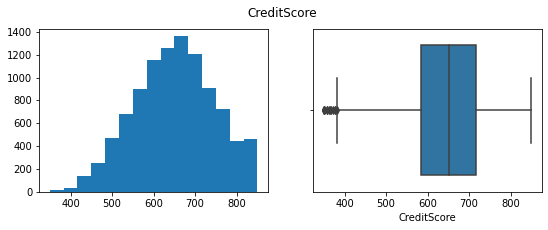

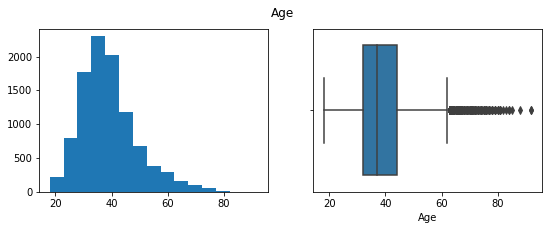

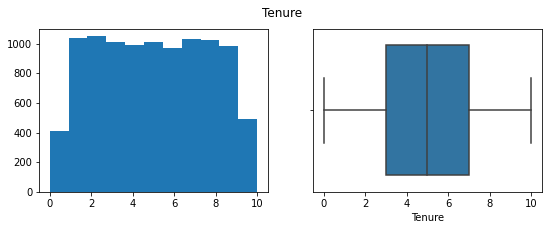

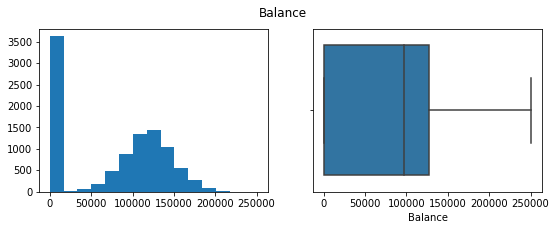

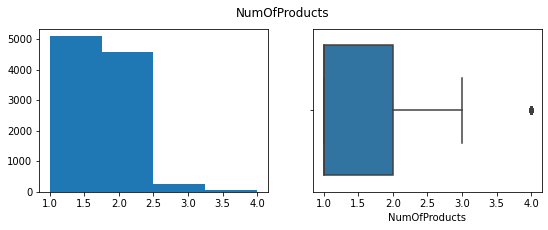

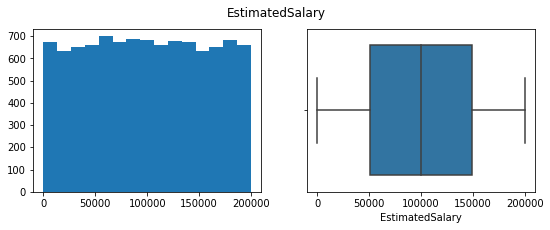

In [14]:
for col in num_cols:
  hist_box(data[col])

Наблюдаются точки за границами boxplot, так что в таблице присутствуют выбросы для следующих признаков: CreditScore, Age, NumOfProducts.



*   Гистограммы для категориальных признаков



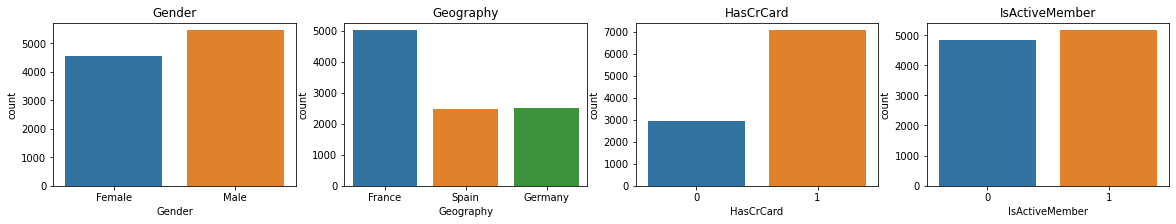

In [15]:
fig = plt.figure(figsize=(20,3))
for i, col in enumerate (['Gender','Geography','HasCrCard','IsActiveMember']): # cat_cols
    ax = fig.add_subplot(1, 4, i+1)
    sns.countplot(x=col, data=data, ax=ax).set_title(col)



*    **Несбалансированность классов**
> Диаграмма целевой переменной







In [16]:
data['Exited'].value_counts()

0    7963
1    2037
Name: Exited, dtype: int64

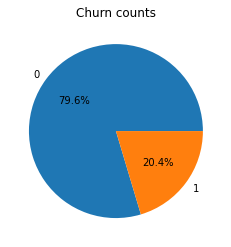

In [21]:
plt.pie(data['Exited'].value_counts().values, labels=data['Exited'].value_counts().index, autopct='%1.1f%%')
plt.title('Churn counts')
pass

Можно видеть, что классы для целевой переменной являются несбалансированными: наблюдается отток примерно 20% клиентов.



*   **Корреляция признаков**


Диаграммы рассеивания для числовых признаков:

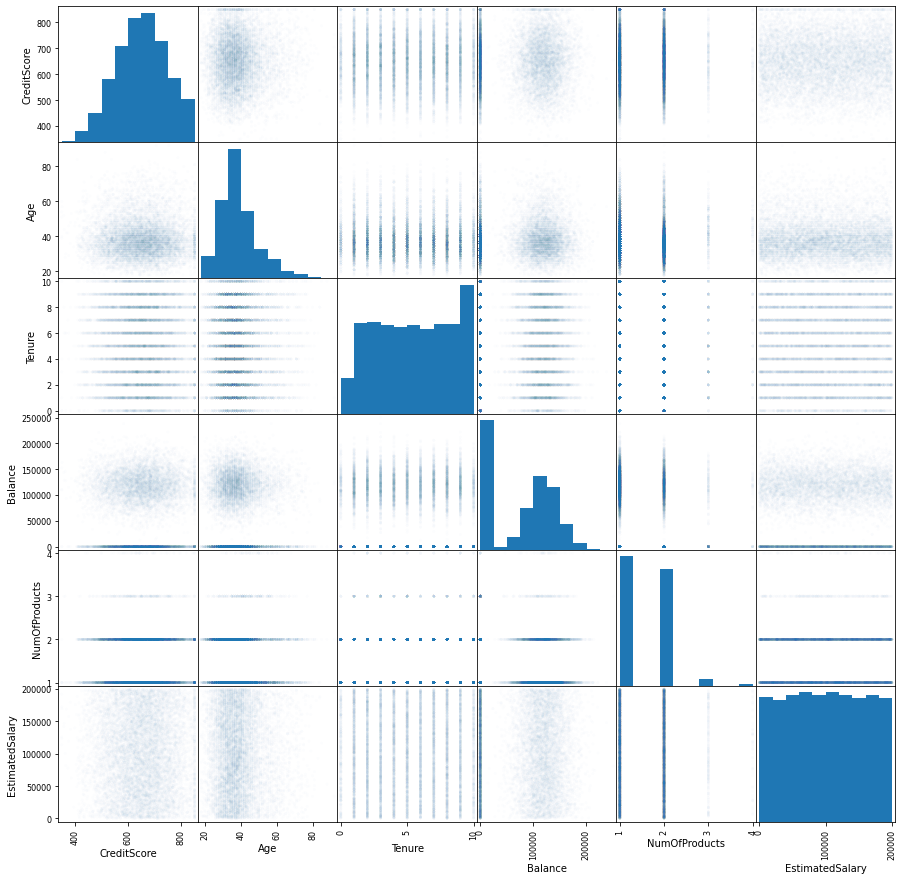

In [22]:
from pandas.plotting import scatter_matrix
df = data.drop(['RowNumber','CustomerId','HasCrCard','IsActiveMember','Exited'], axis=1) # построим без бинарных категориальных признаков
scatter_matrix(df, alpha = .01, figsize = (15, 15))
pass

Можно сделать выводы о кличественных характеристиках разных признаков (кол-во объектов с разными значениями признака), аналогичные тем, что представлены в виде гистограмм выше.

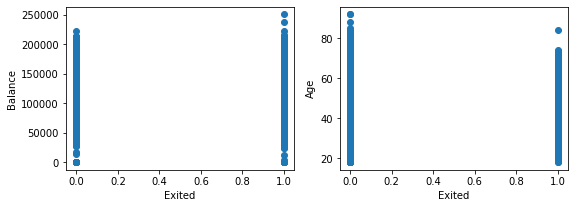

In [23]:
fig,(ax1,ax2) = plt.subplots(1,2,figsize=(9,3))
ax1.scatter(data['Exited'], data['Balance'])
ax1.set_xlabel('Exited')
ax1.set_ylabel('Balance')
ax2.scatter(data['Exited'], data['Age'])
ax2.set_xlabel('Exited')
ax2.set_ylabel('Age')
pass

Такая визуализация в данной задаче не является достаточно информативной для выявления зависимостей целевой переменной от других признаков. Это может быть обсуловлено:
*   постановкой задачи бинарной классификации, а не регрессии
*   слабой корреляцией признаков с целевой переменной и друг с другом
*   большим количеством бинарных признаков.
 Для выявления этих зависимостей построим матрицу корреляции.



 * **Матрица корреляции** 



Построится в том числе для категориальных признаков (бинарных, значения которых в таблице числовые), таких как HasCrCard, IsActiveMember и Exited. 

In [24]:
df = data.drop(['RowNumber','CustomerId'], axis=1)
corr_matr = df.corr()
corr_matr

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
CreditScore,1.000000,-0.003965,0.000842,0.006268,0.012238,-0.005458,0.025651,-0.001384,-0.027094
Age,-0.003965,1.000000,-0.009997,0.028308,-0.030680,-0.011721,0.085472,-0.007201,0.285323
Tenure,0.000842,-0.009997,1.000000,-0.012254,0.013444,0.022583,-0.028362,0.007784,-0.014001
Balance,0.006268,0.028308,-0.012254,1.000000,-0.304180,-0.014858,-0.010084,0.012797,0.118533
NumOfProducts,0.012238,-0.030680,0.013444,-0.304180,1.000000,0.003183,0.009612,0.014204,-0.047820
HasCrCard,-0.005458,-0.011721,0.022583,-0.014858,0.003183,1.000000,-0.011866,-0.009933,-0.007138
IsActiveMember,0.025651,0.085472,-0.028362,-0.010084,0.009612,-0.011866,1.000000,-0.011421,-0.156128
EstimatedSalary,-0.001384,-0.007201,0.007784,0.012797,0.014204,-0.009933,-0.011421,1.000000,0.012097
Exited,-0.027094,0.285323,-0.014001,0.118533,-0.047820,-0.007138,-0.156128,0.012097,1.000000


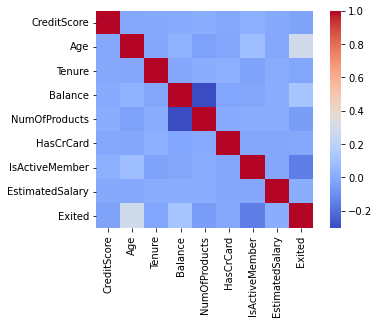

In [25]:
sns.heatmap(corr_matr, square=True, cmap='coolwarm')
pass

Можно видеть, что признаки в среднем слабо коррелируют друг с другом и целевой переменной. Заметна отрицательная корреляция Balance и NumOfProducts(чем больше банковских услгуг клиент купил, тем меньше баланс на счете), положительная корреляция Exited и Age (чем старше)

1.   отрицательная корреляция -30% Balance и NumOfProducts(чем больше банковских услуг клиент купил, тем меньше баланс на счете)
2.   корреляция +28.5% Exited и Age (клиенты старшего возраста чаще закрывают счета)
3.   отрицательная корреляция -15.6% Exited и IsActiveMember. Несмотря на то, что с первого взгляда кажется, что это один и тот же признак, по матрице видно, что активность клиента и закрытие счета коррелируют не так уж сильно.







#3. Обработка пропущенных значений

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           10000 non-null  int64  
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(2), int64(9), object(3)
memory usage: 1.1+ MB


In [ ]:
data.isna().sum().sum()

0

Исходя из таблицы data.info() явных пропусков, т.е. np.nan, в таблице нет. Проверим наличие скрытых пропусков в виде, например, пустых значений.

In [ ]:
data.shape

(10000, 14)

In [ ]:
def check_table():
  for i in range(14):
    col = data.iloc[:,i].astype(str).str.strip()
    ser = col.astype(bool).value_counts()
    if ser[True] < 10000:
      return 0
  return 1

check_table()

1

Из результатов проверки следует, что пропущенных значений нет.

# 4. Обработка категориальных признаков

In [ ]:
cat_cols

['Surname', 'Geography', 'Gender', 'HasCrCard', 'IsActiveMember']

In [ ]:
num_cols

['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'EstimatedSalary']

In [ ]:
data[cat_cols].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Surname         10000 non-null  object
 1   Geography       10000 non-null  object
 2   Gender          10000 non-null  object
 3   HasCrCard       10000 non-null  int64 
 4   IsActiveMember  10000 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 390.8+ KB


Бинарные категориальные признаки HasCrCard и IsActiveMember уже имеют числовые значения. Кроме того, признак Surname не будет использоваться для классификации.

In [6]:
cat_cols.remove('Surname')

In [27]:
cat_cols

['Geography', 'Gender', 'HasCrCard', 'IsActiveMember']

Оставшиеся категориальные признаки закодируем с помощью one got encoding. Объединим их с числовыми (кроме RowNumber) в новую таблицу X для классификации. Целевую переменную Exited для классификации запишем в вектор y.

In [7]:
cat_data = data[cat_cols]
num_data = data[num_cols]
cat_data['Gender'] = pd.factorize(cat_data['Gender'])[0]
dummy_features = pd.get_dummies(cat_data)
y = data[target]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [29]:
dummy_features.sample(5)

,Gender,HasCrCard,IsActiveMember,Geography_France,Geography_Germany,Geography_Spain
4962,0,0,1,1,0,0
7248,0,1,0,0,0,1
7942,0,1,1,1,0,0
334,0,1,0,0,0,1
4970,1,1,1,0,0,1


# 5. Нормализация числовых признаков

Необходимость нормализации вызвана тем, что разные признаки обучающего набора данных могут быть представлены в разных масштабах и изменяться в разных диапазонах. Здесь это, например, CreditScore, Age, Balance, EstimatedSalary.

In [9]:
num_data = data[num_cols]
num_std = (num_data - num_data.mean(axis = 0))/num_data.std(axis = 0)

In [31]:
num_std.head(5)

,CreditScore,Age,Tenure,Balance,NumOfProducts,EstimatedSalary
0,-0.326205,0.293503,-1.041708,-1.225786,-0.911538,0.021885
1,-0.440014,0.198154,-1.387468,0.117344,-0.911538,0.216523
2,-1.536717,0.293503,1.032856,1.332987,2.526930,0.240675
3,0.501496,0.007456,-1.387468,-1.225786,0.807696,-0.108912
4,2.063781,0.388852,-1.041708,0.785689,-0.911538,-0.365258


In [10]:
X = pd.concat([num_std,dummy_features], axis=1)

In [11]:
X.head()

,CreditScore,Age,Tenure,Balance,NumOfProducts,EstimatedSalary,Gender,HasCrCard,IsActiveMember,Geography_France,Geography_Germany,Geography_Spain
0,-0.326205,0.293503,-1.041708,-1.225786,-0.911538,0.021885,0,1,1,1,0,0
1,-0.440014,0.198154,-1.387468,0.117344,-0.911538,0.216523,0,0,1,0,0,1
2,-1.536717,0.293503,1.032856,1.332987,2.526930,0.240675,0,1,0,1,0,0
3,0.501496,0.007456,-1.387468,-1.225786,0.807696,-0.108912,0,0,0,1,0,0
4,2.063781,0.388852,-1.041708,0.785689,-0.911538,-0.365258,0,1,1,0,0,1


Таким образом, из 13 столбцов (без Exited) в таблице, признаками для классификации являются только 10 - 6 числовых и 4 категориальных. Столбец RowNumber дублирует порядковый номер объекта, а Surname и CustomerId не влияют на целевую переменную Exited.

# 6. Разбиение на обучающую и тестовую выборки

In [12]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.33, random_state = 42)
N_train, _ = X_train.shape 
N_test,  _ = X_test.shape 

N_train, N_test

(6700, 3300)

На самом деле, здесь сделано не совсем правильно, потому что разделение на train/test нужно делать до добавления новых признаков/их кодирования и т.д. Иначе возможна утечка информации из test части в train часть. Например, при нормализации обрабатывается весь массив данных, а значит информация из test попадет и в train. Но для упрощения кода выборка обработана заранее.

# 7. Multi-layer Perceptron classifier.

Функция активации и метод минимизации были взяты по умолчанию
(https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html).
Попробуем 1-2 скрытых слоя.

In [14]:
from sklearn.neural_network import MLPClassifier
mlp = MLPClassifier(hidden_layer_sizes = (50,),
                          solver = 'adam',
                          activation = 'relu',
                          random_state = 42)

In [57]:
mlp2 = MLPClassifier(hidden_layer_sizes = (30,30),
                          solver = 'adam',
                          activation = 'relu',
                          random_state = 42)

In [58]:
mlp.fit(X_train, y_train)
mlp2.fit(X_train, y_train)

MLPClassifier(hidden_layer_sizes=(30, 30), random_state=42)

**Проверка качества классификаторов**

1 hidden layer:

In [59]:
y_train_pred = mlp.predict(X_train)
y_test_pred = mlp.predict(X_test)

In [60]:
print(np.mean(y_train != y_train_pred), np.mean(y_test != y_test_pred))

0.1319402985074627 0.13363636363636364


In [61]:
print(mlp.score(X_train, y_train), mlp.score(X_test, y_test))

0.8680597014925373 0.8663636363636363


In [66]:
from sklearn.metrics import confusion_matrix
print(confusion_matrix(y_test_pred, y_test))

[[2524  308]
 [ 133  335]]


2 hidden layers:

In [62]:
y2_train_pred = mlp2.predict(X_train)
y2_test_pred = mlp2.predict(X_test)

In [63]:
print(np.mean(y_train != y2_train_pred), np.mean(y_test != y2_test_pred))

0.12477611940298508 0.1321212121212121


In [64]:
print(mlp.score(X_train, y_train), mlp.score(X_test, y_test))

0.8680597014925373 0.8663636363636363


In [67]:
print(confusion_matrix(y2_test_pred, y_test))

[[2550  329]
 [ 107  314]]


Сравнивая метрики качества для двух моделей, можно видеть, что MLP с двумя скрытыми слоями и немного большим общим количеством нейронов (60 против 50) дает немного лучшие результаты как на train, так и на test. Поэтому рассмотрим зависимость качества модели от значений гиперпараметров. 

# Зависимость ошибки от значений гиперпараметров



*    **Зависимость качества MLP от параметра регуляризации** 



In [40]:
alpha = np.logspace(-2, 2, 20)
test_err = []
train_err = []
train_acc = []
test_acc = []

for a in alpha:
    model = MLPClassifier(alpha = a, hidden_layer_sizes = (30,), 
                              solver = 'lbfgs', activation = 'logistic', max_iter = 1000, random_state = 42, epsilon=1e-6)
    model.fit(X_train, y_train)

    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    
    train_err.append(np.mean(y_train != y_train_pred))
    test_err.append(np.mean(y_test != y_test_pred))
    train_acc.append(model.score(X_train, y_train))
    test_acc.append(model.score(X_test, y_test))


**Как меняется ошибка в зависимости от гиперпараметра:**
*   Error(alpha)


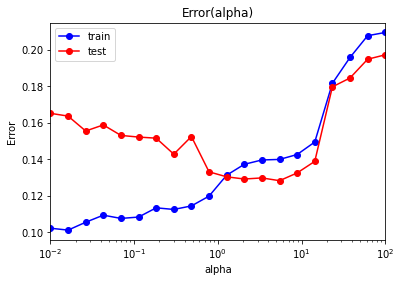

In [41]:
plt.semilogx(alpha, train_err, 'b-o', label = 'train')
plt.semilogx(alpha, test_err, 'r-o', label = 'test')
plt.xlim([np.min(alpha), np.max(alpha)])
plt.title('Error(alpha)')
plt.xlabel('alpha')
plt.ylabel('Error')
plt.legend()
pass


**Как меняется качество модели в зависимости от гиперпараметра:**
*   Accuracy(alpha)



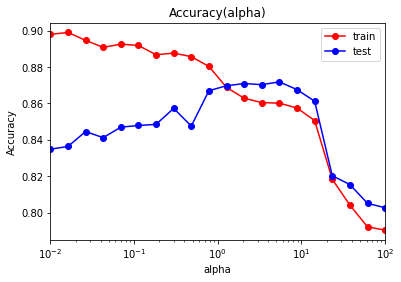

In [42]:
plt.semilogx(alpha, train_acc, 'r-o', label = 'train')
plt.semilogx(alpha, test_acc, 'b-o', label = 'test')
plt.xlim([np.min(alpha), np.max(alpha)])
plt.title('Accuracy(alpha)')
plt.xlabel('alpha')
plt.ylabel('Accuracy')
plt.legend()
pass

**Оптимальное значение alpha:**

In [43]:
min_train_err = np.min(train_err)
min_test_err = np.min(test_err)
print(min_train_err, min_test_err)

0.10104477611940299 0.12818181818181817


In [44]:
alpha_opt = alpha[test_err == min_test_err]
print(alpha_opt)

[5.45559478]


Далее будем ориентироваться на порядок величины найденного оптимального значения.



*  **Зависимость качества MLP от количества нейронов** 



*   1 скрытый слой



In [45]:
num_neurons = np.linspace(5,55,25) 
test_err = []
train_err = []
train_acc = []
test_acc = []
for n in num_neurons:
    model = MLPClassifier(alpha = alpha_opt, hidden_layer_sizes = (int(n),), 
                              solver = 'lbfgs', activation = 'logistic', 
                                 max_iter=1000, random_state = 42,  epsilon = 1e-5)
    model.fit(X_train, y_train)
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    train_err.append(np.mean(y_train != y_train_pred))
    test_err.append(np.mean(y_test != y_test_pred))
    train_acc.append(model.score(X_train, y_train))
    test_acc.append(model.score(X_test, y_test))


**1 layer**
*   Error(hidden_layer_size)



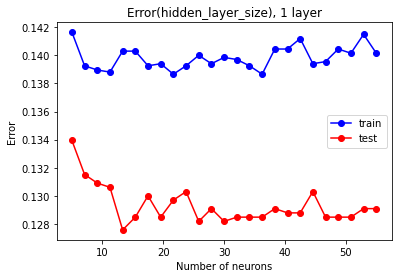

In [46]:
plt.plot(num_neurons, train_err, 'b-o', label = 'train')
plt.plot(num_neurons, test_err, 'r-o', label = 'test')
plt.title('Error(hidden_layer_size), 1 layer')
plt.xlabel('Number of neurons')
plt.ylabel('Error')
plt.legend()
pass

**1 layer**
*   Accuracy(hidden_layer_size)

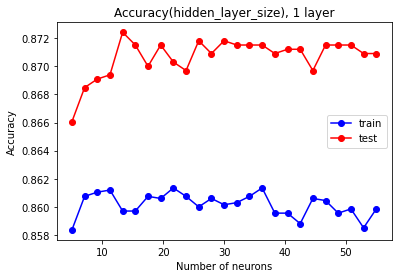

In [50]:
plt.plot(num_neurons, train_acc, 'b-o', label = 'train')
plt.plot(num_neurons, test_acc, 'r-o', label = 'test')
plt.title('Accuracy(hidden_layer_size), 1 layer')
plt.xlabel('Number of neurons')
plt.ylabel('Accuracy')
plt.legend()
pass

При увеличении количества нейронов, точность и ошибка выходит на плато. Переобучения в рассмотренном диапазоне значений не происходит. Недообучение при num_neurons < 10.
Отметим, что ошибка на train получилась **меньше** ошибки на test. Причин данного поведения зависимостей не было найдено.

Минимальное значение ошибки:

In [51]:
min_train_err = np.min(train_err)
min_test_err = np.min(test_err)
print(min_train_err, min_test_err)

0.13865671641791044 0.12757575757575756


In [52]:
opt_num = num_neurons[test_err == min_test_err]
print(opt_num)

[13.33333333]


Оптимальное значение количества нейронов далее будет использовано при поиске оптимального параметра регуляризации.
При рассмотрении классификатора MLP с двумя скрытыми слоями, будет использован тот же порядок значений кол-ва нейронов.



*   2 скрытых слоя



In [57]:
second_layer = np.linspace(5,25,20)
test_err = []
train_err = []
train_acc = []
test_acc = []
for n in second_layer:
    model = MLPClassifier(alpha = 2, hidden_layer_sizes = (5, int(n)), 
                              solver = 'lbfgs', activation = 'logistic', 
                                 max_iter=1000, random_state = 42, epsilon = 1e-5)
    model.fit(X_train, y_train)
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    train_err.append(np.mean(y_train != y_train_pred))
    test_err.append(np.mean(y_test != y_test_pred))
    train_acc.append(model.score(X_train, y_train))
    test_acc.append(model.score(X_test, y_test))


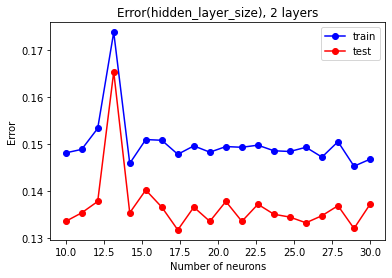

In [58]:
num_neurons = second_layer + 5
plt.plot(num_neurons, train_err, 'b-o', label = 'train')
plt.plot(num_neurons, test_err, 'r-o', label = 'test')
plt.title('Error(hidden_layer_size), 2 layers')
plt.xlabel('Number of neurons')
plt.ylabel('Error')
plt.legend()
pass

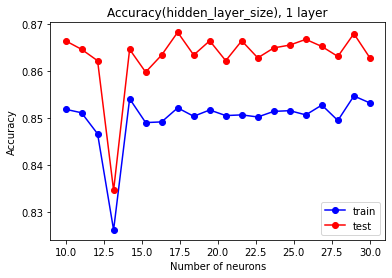

In [60]:
plt.plot(num_neurons, train_acc, 'b-o', label = 'train')
plt.plot(num_neurons, test_acc, 'r-o', label = 'test')
plt.title('Accuracy(hidden_layer_size), 2 layers')
plt.xlabel('Number of neurons')
plt.ylabel('Accuracy')
plt.legend()
pass

При изменении количества нейронов в классификаторе с двумя слоями, точность ведет себя аналогично зависимости для модели с одним слоем, за исключением "артефакта" при общем количестве нейронов = 13.  

**Классификатор при найденных оптимальных значениях гиперпараметров**

In [61]:
best_model = MLPClassifier(alpha = alpha_opt, hidden_layer_sizes = (int(opt_num),),
                          solver = 'lbfgs', activation = 'logistic', random_state = 42)
best_model.fit(X_train, y_train)

y_train_pred = best_model.predict(X_train)
y_test_pred = best_model.predict(X_test)
print(np.mean(y_train != y_train_pred))
print(np.mean(y_test != y_test_pred))

0.14029850746268657
0.12757575757575756


In [63]:
print(confusion_matrix(y_test_pred, y_test))

[[2569  333]
 [  88  310]]


**Вывод.**
При увеличении сложности модели MLP(количества нейронов) c одним скрытым слоем, точность и ошибка выходит на плато. Следовательно, переобучения в рассмотренном диапазоне значений не происходит. Недообучение при num_neurons < 10.
Такое поведение наблюдается при достаточно больших параметрах регуляризации(alpha > 1). Было также замечено, что при default значении alpha(alpha_default=0.0001) поведение этих зависимостей хаотично.
Отметим, что ошибка на train получилась **меньше** ошибки на test. Причин данного поведения зависимостей не было найдено.